### Total capacity estimation using recursive AWTLS
This notebook implements the recursive AWTLS method using the same data set you are already familiar with from last week. Remember that the true capacity of this cell is 10.0 Ah.

WTLS estimate after 10 Newton-Raphson iterations: 10.050015 +/- 0.487120
Final AWTLS estimate (using all data): 10.025941 +/- 0.478861


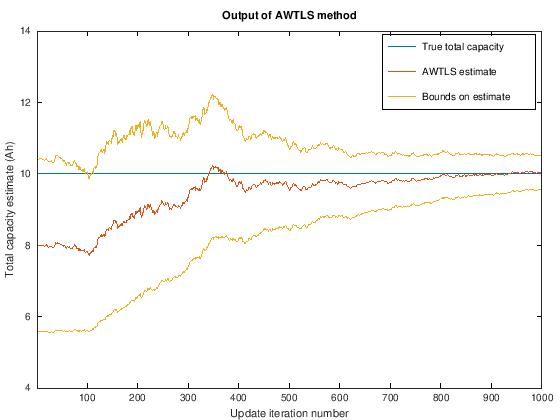

In [1]:
%% Set up data for problem
load readonly/Lesson425data.mat

%% WTLS -- not recursive, uses all data to produce single estimate
sigmax = sqrt(Sigmax); % std-dev of x 
sigmay = sqrt(Sigmay); % std-dev of y
Qhat = 5; % purposefully bad initialization of Qhat
for k = 1:10,
  jacobian = sum((2*(Qhat*x-y).*(Qhat*y.*sigmax.^2+x.*sigmay.^2))./...
                 ((Qhat^2*sigmax.^2+sigmay.^2).^2));
  hessian = sum((2*sigmay.^4.*x.^2+sigmax.^4.*...
                (6*Qhat^2*y.^2-4*Qhat^3*x.*y) - ...
                 sigmax.^2.*sigmay.^2.*...
                (6*Qhat^2*x.^2-12*Qhat*x.*y+2*y.^2))./...
                ((Qhat^2*sigmax.^2+sigmay.^2).^3));
  Qhat = Qhat - jacobian/hessian;
  SigmaQ = 2/hessian;
  boundsQ = 3*sqrt(SigmaQ);
end
fprintf('WTLS estimate after %d Newton-Raphson iterations: %f +/- %f\n',k,Qhat,boundsQ);

%% AWTLS -- recursive, updates estimate every time new data become available
Qnom = 8;                        % Initialize nominal capacity
SYinit = 0.01;                    % Uncertainty of Q with respect to Qnom
c1 = 1/SYinit;                    % Correct initialization of c1 recursive value
c2 = Qnom/SYinit;                 % Correct initialization of c2 recursive value
c3 = Qnom^2/SYinit;               % Correct initialization of c3 recursive value
% Init c4...c6 assuming SXinit = SYinit to match TLS
c4 = 1/SYinit;                    % Correct initialization of c4 recursive value
c5 = Qnom/SYinit;                 % Correct initialization of c5 recursive value
c6 = Qnom^2/SYinit;               % Correct initialization of c6 recursive value

Qhat = 0*x;                       % Initialize storage for output estimate
SigmaQ = 0*x;                     % Initialize storage for estimation-error variance
for k = 1:length(x),
  c1 = c1 + x(k)^2/Sigmay(k);     % Update c1 recursive parameter
  c2 = c2 + x(k)*y(k)/Sigmay(k);  % Update c2 recursive parameter
  c3 = c3 + y(k)^2/Sigmay(k);     % Update c3 recursive parameter
  c4 = c4 + x(k)^2/Sigmax(k);     % Update c4 recursive parameter
  c5 = c5 + x(k)*y(k)/Sigmax(k);  % Update c5 recursive parameter
  c6 = c6 + y(k)^2/Sigmax(k);     % Update c6 recursive parameter
  
  r = roots([c5 (-c1+2*c4-c6) (3*c2-3*c5) (c1-2*c3+c6) -c2]);
  r = r(r==conj(r));
  r = r(r>0);
  Jr = ((1./(r.^2+1).^2).*(r.^4*c4-2*c5*r.^3+(c1+c6)*r.^2-2*c2*r+c3))';
  Q = r(Jr==min(Jr));
  J = min(Jr);
  H = (2/(Q^2+1)^4)*(-2*c5*Q^5+(3*c1-6*c4+3*c6)*Q^4+(-12*c2+16*c5)*Q^3 ...
        +(-8*c1+10*c3+6*c4-8*c6)*Q^2+(12*c2-6*c5)*Q+(c1-2*c3+c6));
  Qhat(k) = Q;
  SigmaQ(k) = 2/H;
  
  
end

xvals = 1:length(Qhat);
plot(xvals,10*ones(size(Qhat)),xvals,Qhat,[xvals,NaN,xvals],[Qhat+3*sqrt(SigmaQ),NaN,Qhat-3*sqrt(SigmaQ)]);
xlabel('Update iteration number'); ylabel('Total capacity estimate (Ah)');
title('Output of AWTLS method');   xlim([1 1000]);
legend('True total capacity','AWTLS estimate','Bounds on estimate','location','northeast');

fprintf('Final AWTLS estimate (using all data): %f +/- %f\n',Qhat(end),3*sqrt(SigmaQ(end)));